# 1. Imports, Cleaning and EDA

## 1.1. Imports

In [2]:
from pySimFinLIB import pySimFin
import pandas as pd
import seaborn as sns
from simfin.names import *
import matplotlib.pyplot as plt
import requests
from dotenv import load_dotenv
import os
import pandas as pd

import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LinearSegmentedColormap

## 1.2 Data Cleaning

In [3]:
ticker = 'AAPL'
startDate = '2022-01-01'
endDate = '2023-01-01'

In [4]:
psf = pySimFin()

In [5]:
infoDF = psf.getCompanyInfo(ticker)
companyDF = psf.getCompanyList()
pricesDF = psf.getStockPrices(ticker,startDate,endDate)

In [6]:
companyDF

,id,name,ticker,sectorCode,industryName,sectorName,isin
0,1234791,STERLING BANCORP,STL,104002.0,Financial Services,Banks,US85917A1007
3,1253409,Infosys Ltd,INFY,101003.0,Technology,Application Software,US4567881085
4,1291790,ACCELERON PHARMA INC,XLRN,106001.0,Healthcare,Medical Diagnostics & Research,US00434H1086
42,65359,ALEXION PHARMACEUTICALS INC,ALXN,106002.0,Healthcare,Biotechnology,US0153511094
48,76840,"REMEDENT, INC.",REMI,106003.0,Healthcare,Medical Instruments & Equipment,US75954T1043
...,...,...,...,...,...,...,...
6264,18599360,Seanergy Maritime Holdings Corp.,SHIP,100010.0,Industrials,Transportation & Logistics,MHY737601945
6265,18599362,Wix.com Ltd.,WIX,101003.0,Technology,Application Software,IL0011301780
6266,18599364,Sprott Physical Platinum and Palladium Trust,SPPP,104001.0,Financial Services,Asset Management,CA85207Q1046
6267,18599366,Sportradar Group AG,SRAD,101003.0,Technology,Application Software,CH1134239669


In [7]:
stock_data = psf.getStockPrices(ticker, startDate, endDate)
stock_data 

,Common Shares Outstanding,Last Closing Price,Adjusted Closing Price,Highest Price,Lowest Price,Opening Price,Trading Volume
Date,,,,,,,
2022-01-03,16687631000,182.01,178.89,182.88,177.71,177.83,104701220
2022-01-04,16687631000,179.70,176.61,182.94,179.12,182.63,99310438
2022-01-05,16687631000,174.92,171.92,180.17,174.64,179.61,94537602
2022-01-06,16687631000,172.00,169.05,175.30,171.64,172.70,96903955
2022-01-07,16687631000,172.17,169.21,174.14,171.03,172.89,86709147
...,...,...,...,...,...,...,...
2022-12-23,16030382000,131.86,130.35,132.41,129.64,130.92,63814893
2022-12-27,16030382000,130.03,128.54,131.41,128.72,131.38,69007830
2022-12-28,16030382000,126.04,124.60,131.03,125.87,129.67,85438391


In [8]:
def selectMultipleStocks(selected_stocks, startDate, endDate):
    selected_stock_data = {}

    for ticker in selected_stocks:
        # Get stock data for each ticker
        stock_data = psf.getStockPrices(ticker, startDate, endDate)
        stock_data = stock_data['Last Closing Price']
        
        
        # Store stock data in the dictionary with the ticker as the key
        selected_stock_data[ticker] = stock_data

    return pd.DataFrame(selected_stock_data)

In [9]:


selected_stocks = ['AAPL','AMZN','NFLX','GOOG']

psf.selectMultipleStocks(selected_stocks, startDate, endDate)

,AAPL,AMZN,NFLX,GOOG
Date,,,,
2022-01-03,182.01,170.40,597.37,145.07
2022-01-04,179.70,167.52,591.15,144.42
2022-01-05,174.92,164.36,567.52,137.65
2022-01-06,172.00,163.25,553.29,137.55
2022-01-07,172.17,162.55,541.06,137.00
...,...,...,...,...
2022-12-23,131.86,85.25,294.96,89.81
2022-12-27,130.03,83.04,284.17,87.93
2022-12-28,126.04,81.82,276.88,86.46


In [10]:
def tickerFind(nameList,companyDF):
    tickerList = []
    for name in nameList:
        for index, company in companyDF.iterrows():
            if name == company['name']:
                tickerList.append(company['ticker'])
    return tickerList

names = list(companyDF['name'].sample(5))

tickerFind(names,companyDF)

['MANH', 'UDMY', 'PINE', 'VLY', 'DCT']

# TS Modelling

In [11]:
psf = pySimFin()

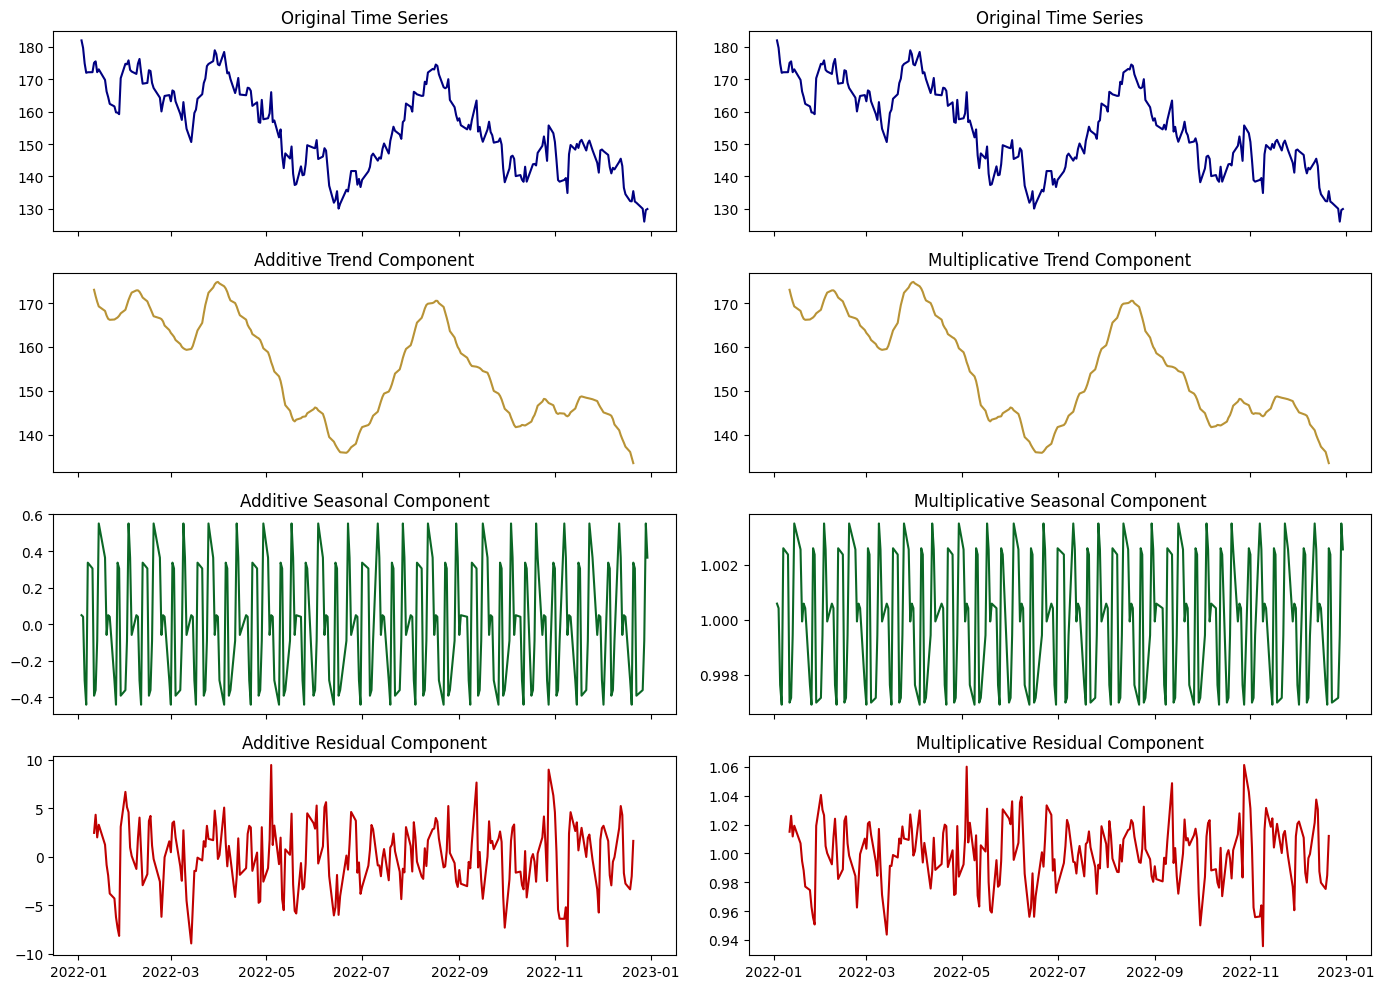

In [14]:
stockPrice = psf.selectSingleStock('AAPL', startDate, endDate)

additive_decomposition = seasonal_decompose(stockPrice, model="additive", period=12)
multiplicative_decomposition = seasonal_decompose(stockPrice, model="multiplicative", period=12)

# Plot both decompositions side by side
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

navy = "#000080"
gold = "#B89336"
green = "#0B6725"
red = "#C00000"

# Additive Decomposition Plots
axes[0, 0].plot(stockPrice.index, stockPrice, color="#000080")
axes[0, 0].set_title("Original Time Series")

axes[1, 0].plot(stockPrice.index, additive_decomposition.trend, color="#B89336")
axes[1, 0].set_title("Additive Trend Component")

axes[2, 0].plot(stockPrice.index, additive_decomposition.seasonal, color="#0B6725")
axes[2, 0].set_title("Additive Seasonal Component")

axes[3, 0].plot(stockPrice.index, additive_decomposition.resid, color="#C00000")
axes[3, 0].set_title("Additive Residual Component")

# Multiplicative Decomposition Plots
axes[0, 1].plot(stockPrice.index, stockPrice, color="#000080")
axes[0, 1].set_title("Original Time Series")

axes[1, 1].plot(stockPrice.index, multiplicative_decomposition.trend, color="#B89336")
axes[1, 1].set_title("Multiplicative Trend Component")

axes[2, 1].plot(stockPrice.index, multiplicative_decomposition.seasonal, color="#0B6725")
axes[2, 1].set_title("Multiplicative Seasonal Component")

axes[3, 1].plot(stockPrice.index, multiplicative_decomposition.resid, color="#C00000")
axes[3, 1].set_title("Multiplicative Residual Component")

plt.tight_layout()
plt.show()

In [19]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def compare_decompositions(ts, model_type='multiplicative'):
    ts = ts.dropna()
    if model_type == 'multiplicative':
        decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative', period=12)
    else:
        decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=12)

    # Get the decomposed components
    trend = decomposition.trend.dropna()
    seasonal = decomposition.seasonal.dropna()
    residual = decomposition.resid.dropna()

    # Calculate errors between original and fitted series
    fitted_values = trend + seasonal + residual if model_type == 'additive' else trend * seasonal * residual

    # Evaluate performance using MAE and RMSE
    mae = mean_absolute_error(ts, fitted_values)
    rmse = root_mean_squared_error(ts, fitted_values, squared=False)

    return mae, rmse

In [35]:
stockPrice = psf.selectSingleStock('AAPL', startDate, endDate)

decomposition = sm.tsa.seasonal_decompose(stockPrice, model='multiplicative', period=7)

# Check if any of the components have NaN values
print("Trend NaNs:", decomposition.trend.isna().sum())
print("Seasonal NaNs:", decomposition.seasonal.isna().sum())
print("Residual NaNs:", decomposition.resid.isna().sum())

Trend NaNs: 6
Seasonal NaNs: 0
Residual NaNs: 6
